In [1]:
!which pip3

/home/mgross/anaconda3/envs/contrast-net/bin/pip3


In [2]:
! nvidia-smi

Thu Jan 29 04:58:49 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:17:00.0 Off |                  Off |
| 34%   36C    P8              23W / 260W |   2118MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
from monai.visualize import img2tensorboard
import torch
import time
import sklearn

from torch.utils.data import DataLoader

from monai.data.utils import pad_list_data_collate

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, Resized, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent, RandFlipd
#LoadNiftid


from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.transforms import KeepLargestConnectedComponent

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm





monai.config.print_config()

MONAI version: 0.7.0
Numpy version: 1.20.3
Pytorch version: 1.8.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [5]:
INPUT_PATH = '../ContrastNets.xlsx'
df = pd.read_excel(INPUT_PATH, index_col=False)

In [6]:
df_train, df_val, df_test = \
              np.split(df.sample(frac=1, random_state=50), 
                       [int(.7*len(df)), int(.85*len(df))])


df_train['DATA_SPLIT'] = 'Train'
df_val['DATA_SPLIT'] = 'Val'
df_test['DATA_SPLIT'] = 'Test'


df = pd.concat([df_train, df_val, df_test])

In [7]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')

## Setup Input Transformations

In [8]:
SPACING = (2.0,2.0,2.0)
#PATCH_SIZE = (96,96,16)
PATCH_SIZE = (64,64,32)




train_transforms = Compose([
    LoadImaged(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE','ART', 'PV', 'DEL', 'SEGM']),
    Orientationd(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'], axcodes='RAS'),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    Spacingd(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection','reflection', 'reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE','ART', 'PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'], spatial_size=PATCH_SIZE, padding_mode=('reflection','reflection','reflection', 'reflection','reflection'), ),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'], label_key='SEGM', spatial_size=PATCH_SIZE, pos=3, neg=1, num_samples=2),
    RandFlipd(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'], prob=0.5, spatial_axis=0),
    ToTensord(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'])
])

val_transforms = Compose([
     LoadImaged(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE','ART', 'PV', 'DEL', 'SEGM']),
    Orientationd(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection','reflection', 'reflection','reflection')),
    #Resized(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'], spatial_size=PATCH_SIZE),
    ScaleIntensityRangePercentilesd(keys=['PRE','ART', 'PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'])
])

test_transforms = Compose([
    LoadImaged(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE','ART', 'PV', 'DEL', 'SEGM']),
    Orientationd(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection','reflection', 'reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE','ART', 'PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['PRE','ART', 'PV', 'DEL', 'SEGM'])
])


inference_transforms = Compose([
     LoadImaged(keys=['PRE','ART', 'PV', 'DEL'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE','ART', 'PV', 'DEL']),
    Orientationd(keys=['PRE','ART', 'PV', 'DEL'], axcodes='RAS'),
    Spacingd(keys=['PRE','ART', 'PV', 'DEL'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear','bilinear'), padding_mode=('reflection','reflection','reflection', 'reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE','ART', 'PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['PRE','ART', 'PV', 'DEL'])
])



## Create a Persistent Data Cache for Training and Validation Data

In [9]:
CACHE_PATH = '/tensor5/data1/mgross/Liver/studies/Contrast-Nets/4mpMRI-Net/monai_cache'


In [10]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=pad_list_data_collate)

In [11]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH,
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4,# collate_fn=list_data_collate,
                       collate_fn=pad_list_data_collate)

In [12]:
test_ds = monai.data.PersistentDataset(
    data=test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4, collate_fn=pad_list_data_collate)

## Check Input Data

torch.Size([8, 1, 64, 64, 32])
torch.Size([8, 1, 64, 64, 32])
torch.Size([8, 1, 64, 64, 32])
torch.Size([8, 1, 64, 64, 32])
12947616
PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.5749169588088989
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.5843901038169861
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.7536075711250305
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.7734526991844177


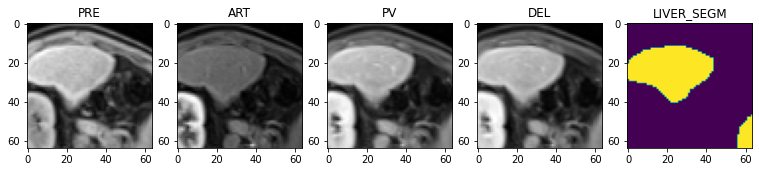

12947616
PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.6447254419326782
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.6002316474914551
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.7975389957427979
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.8199068307876587


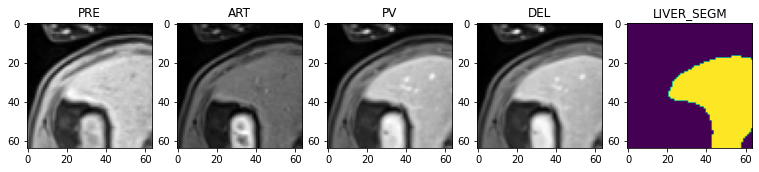

E101805234
PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: -0.07976194471120834
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: -0.23699845373630524
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: -0.23377971351146698
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: -0.22210347652435303


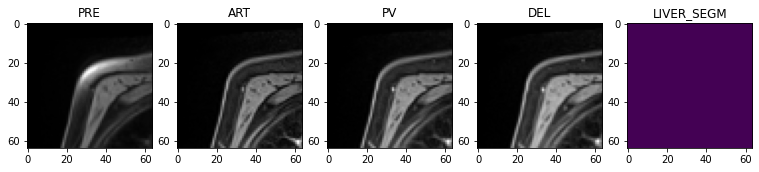

E101805234
PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.6021753549575806
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.5694054961204529
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.698524534702301
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.6423309445381165


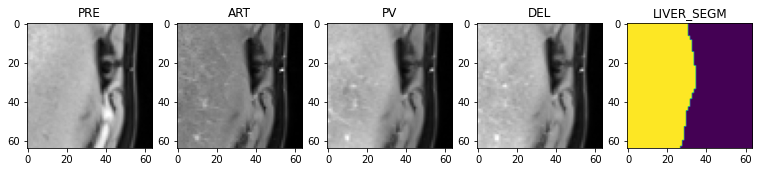

9664279
PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.5066589713096619
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.5776463150978088
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.6996689438819885
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.6741414666175842


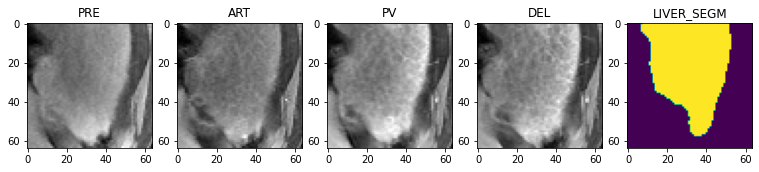

9664279
PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.938506007194519
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 1.1925997734069824
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 1.379311203956604
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 1.2415283918380737


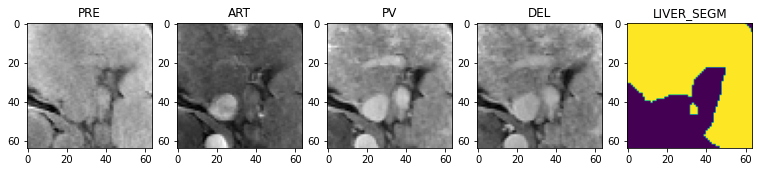

E101399721
PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.6243103742599487
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.9084069132804871
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.9744873046875
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.7999545335769653


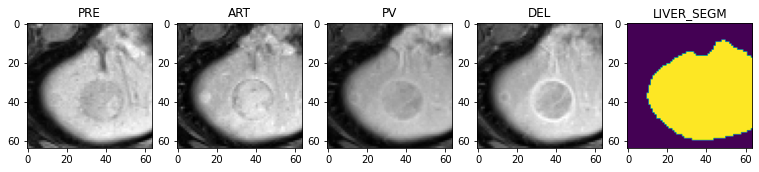

E101399721
PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.3018149435520172
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.5362966060638428
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.5720664858818054
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.483754962682724


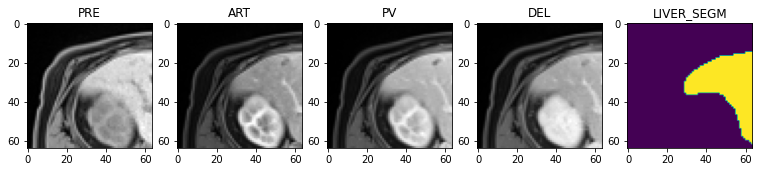

In [13]:
check_ds = monai.data.Dataset(data=train_data_dict[:4], transform=train_transforms)
#check_ds = monai.data.Dataset(data=val_data_dict[:1], transform=val_transforms)
#check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)


check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=pad_list_data_collate) #collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['PRE'].shape)
print(check_data['ART'].shape)
print(check_data['PV'].shape)
print(check_data['DEL'].shape)


num_display = 10
if check_data['ART'].shape[0] < num_display:
    num_display = check_data['ART'].shape[0]

for i in range(num_display):
    acc_id, PRE, ART, PV, DEL , liver_label = (check_data['ACCESSION_ID'][i], check_data['PRE'][i][0],check_data['ART'][i][0],check_data['PV'][i][0],check_data['DEL'][i][0], check_data['SEGM'][i][0])
    print(acc_id)
    print('PRE shape: {}, label shape: {}'.format(PRE.shape, liver_label.shape))
    print('PRE mean: {}'.format(np.mean(PRE.numpy())))

    
    print('ART shape: {}, label shape: {}'.format(ART.shape, liver_label.shape))
    print('ART mean: {}'.format(np.mean(ART.numpy())))
    
    
    print('PV shape: {}, label shape: {}'.format(PV.shape, liver_label.shape))
    print('PV mean: {}'.format(np.mean(PV.numpy())))
    
    print('DEL shape: {}, label shape: {}'.format(DEL.shape, liver_label.shape))
    print('DEL mean: {}'.format(np.mean(DEL.numpy())))



    slice_num = ART.shape[2]//2
    
    plt.figure('check', (13, 15))

    plt.subplot(1, 5, 1)
    plt.title('PRE')
    plt.imshow(PRE[:,:,slice_num], cmap='gray')

 
    
    plt.subplot(1, 5, 2)
    plt.title('ART')
    plt.imshow(ART[:,:,slice_num], cmap='gray')

    plt.subplot(1, 5, 3)
    plt.title('PV')
    plt.imshow(PV[:,:,slice_num], cmap='gray')
    
    plt.subplot(1, 5 ,4)
    plt.title('DEL')
    plt.imshow(DEL[:,:,slice_num], cmap='gray')

    

    plt.subplot(1, 5, 5)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    plt.show()


    


## Create Segmentation Model (U-net)

In [14]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=4, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            #channels=(64, 128, 256, 512),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout = dropout_rate,
        )

    
        self.loss_function = monai.losses.DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
        self.val_metric = DiceMetric(include_background=False)

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):
        
        pre_images =  batch["PRE"]
        art_images =  batch["ART"]
        pv_images =  batch["PV"]
        del_images =  batch["DEL"]
        
        images = torch.cat((pre_images, art_images, pv_images, del_images) ,dim=1)
        labels = batch["SEGM"]
        
        
        #images, labels = batch["IMAGE"], batch["SEGM"]
        #print(batch['ACCESSION_ID'])
        
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            #sample_input = torch.rand((1,1,96,96,16))
            sample_input = torch.rand((1,4,64,64,32))
            self.logger.experiment.add_graph(
                MRILiverSegmentation(), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    

    def validation_step(self, batch, batch_idx):
        
        
        pre_images =  batch["PRE"]
        art_images =  batch["ART"]
        pv_images =  batch["PV"]
        del_images =  batch["DEL"]
        
        
        images = torch.cat((pre_images, art_images, pv_images, del_images) ,dim=1)
        labels = batch["SEGM"]
        
        
        #images = batch["IMAGE"]
        #labels = batch["SEGM"]

        #roi_size = (256, 256, 48)
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)

#         one_hot = monai.networks.utils.one_hot(labels, num_classes=3)
        argmax = torch.argmax(outputs, dim=1, keepdim=True)
        val_dice = self.val_metric(
            self.one_hot_transform(argmax), 
            self.one_hot_transform(labels)
        )
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}
    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss)
        self.log('val_dice', avg_dice)

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-4)
    
    

In [15]:
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRILiverSegmentation()
#summary(model.to(device), [1,1,96,96,16])
summary(model.to(device), [1,4,64,64,32])

Layer (type:depth-idx)                                                           Output Shape              Param #
MRILiverSegmentation                                                             --                        --
├─UNet: 1-1                                                                      [1, 2, 64, 64, 32]        --
│    └─Sequential: 2-1                                                           [1, 2, 64, 64, 32]        --
│    │    └─ResidualUnit: 3-1                                                    [1, 16, 32, 32, 16]       10,482
│    │    └─SkipConnection: 3-2                                                  [1, 32, 32, 32, 16]       1,178,186
│    │    └─Sequential: 3-3                                                      [1, 2, 64, 64, 32]        1,845
Total params: 1,190,513
Trainable params: 1,190,513
Non-trainable params: 0
Total mult-adds (G): 1.72
Input size (MB): 2.10
Forward/backward pass size (MB): 45.22
Params size (MB): 4.76
Estimated Total Size (MB)

## Model Training

In [16]:
MODEL_ROOT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/4mpMRI-Net'

In [17]:
# initialise the LightningModule
model = MRILiverSegmentation(dropout_rate=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_ROOT_PATH,'saved_model'),
    filename="MRILiverSegmentation-{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_on_train_epoch_end=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=2000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=20,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:45: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:730: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1893: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit ch

Validation sanity check: 0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


## Model Testing

In [18]:
os.listdir(os.path.join(MODEL_ROOT_PATH,'saved_model'))

['last.ckpt',
 'logs',
 'MRILiverSegmentation-epoch=0900-val_loss=0.06.ckpt',
 'MRILiverSegmentation-epoch=0899-val_loss=0.06.ckpt']

In [19]:
model_path = os.path.join(MODEL_ROOT_PATH,'saved_model','MRILiverSegmentation-epoch=0899-val_loss=0.06.ckpt')

model = MRILiverSegmentation.load_from_checkpoint(model_path)
# model.load_from_checkpoint(model_path)
model.eval()
device = torch.device("cuda:0")
model.to(device)

MRILiverSegmentation(
  (_model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        

In [20]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        if keep:
            dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
        else:
                
            # Calculate Dice on the raw output
            dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            
            
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    output_paths = list()
    
    acc_ids = list()
    input_paths = list()
    output_results = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    
            pre_images =  test_data["PRE"].to(device)
            art_images =  test_data["ART"].to(device)
            pv_images =  test_data["PV"].to(device)
            del_images =  test_data["DEL"].to(device)

            x = torch.cat((pre_images, art_images, pv_images, del_images) ,dim=1)
            y = test_data['SEGM'].cpu()




            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                pre_img = pre_images.detach().cpu()
                art_img = art_images.detach().cpu()
                pv_img = pv_images.detach().cpu()
                del_img = del_images.detach().cpu()



                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 6, 1)
                plt.title('PRE')
                plt.imshow(pre_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 6, 2)
                plt.title('ART')
                plt.imshow(art_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 6, 3)
                plt.title('PV')
                plt.imshow(pv_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 6, 4)
                plt.title('DEL')
                plt.imshow(del_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 6, 5)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 6, 6)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()
                
                
                
            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['ART_meta_dict']['affine'][0].numpy()
                original_affine = test_data['ART_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['ART_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['ART_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )



    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [21]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/4-phases/'

0it [00:00, ?it/s]

0.9696099758148193
4.024811275847795
inf
0.9709620475769043
1.1579217823278292
inf
torch.Size([1, 2, 201, 151, 108])
torch.Size([1, 201, 151, 108])


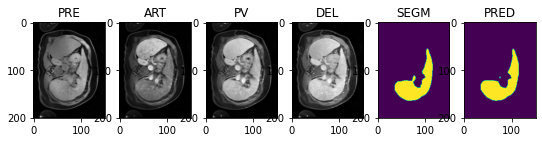

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/4-phases/E100998852_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 48 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 49 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 50 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

0.9704592823982239
13.778653193506306
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 47 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 48 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 49 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9773465394973755
1.2671657650148354
inf
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


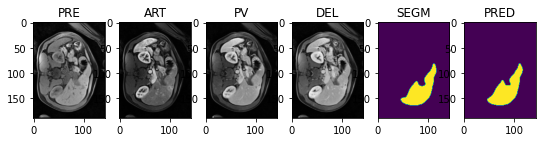

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/4-phases/12370686_T1_ART_segm.nii.gz
[0.9696099758148193, 0.9704592823982239]


,DICE,POST_DICE,HD95,POST_HD95,InferenceTime,AUTOMATED-LIVER-SEGM,EXPERIMENT_ID
0,0.969610,0.970962,4.024811,1.157922,0.006781,/tensor5/data1/mgross/Liver/studies/Contrast-N...,4mpMRI-Contrast-Imaging
1,0.970459,0.977347,13.778653,1.267166,0.005418,/tensor5/data1/mgross/Liver/studies/Contrast-N...,4mpMRI-Contrast-Imaging


In [43]:
roi_size = (224, 224, 128)

df_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
    output_path= OUTPUT_PATH,
    max_eval = 2)

torch.cuda.empty_cache()
df_test_results['EXPERIMENT_ID'] = '4mpMRI-Contrast-Imaging'
df_test_results.head()

In [55]:
df_test_results.to_csv('../Results/Results-4mpMRI-Net.csv')

## External Testing

In [22]:
import glob 
import pandas as pd

external_testing_img_paths = pd.read_csv('/tensor5/data1/jonofrey/Liver/Paris/registration/nonrigid_nmi/Nonrigid_Registered_NMI_Image_Paths.csv')

included_accs = [1,3, 4, 6, 10, 11, 12, 17, 18, 19, 22, 32, 35, 40, 55, 59]
external_testing_img_paths = external_testing_img_paths[external_testing_img_paths['ACCESSION_ID'].isin(included_accs)]

segm_path = '/tensor5/data1/mgross/Liver/Paris/man_liver_segms/*_PV_LIVER-label.nii.gz'
segm_paths = glob.glob(segm_path)

external_testing_accs = [int(i.split('/')[-1].split('_')[0]) for i in segm_paths]

df_external_testing = pd.DataFrame({'ACCESSION_ID': external_testing_accs, 'SEGM' : segm_paths})
df_external_testing = pd.merge(external_testing_img_paths, df_external_testing, on = 'ACCESSION_ID')

df_external_testing = df_external_testing[['ACCESSION_ID','PV_PRE','PV_ART','PV','PV_DEL',  'SEGM']]



df_external_testing.rename(columns={'PV_PRE' : 'PRE',
                                    'PV_ART' : 'ART',
                                    'PV_DEL' : 'DEL',
                                    'LIVER': 'SEGM'}, inplace = True)
df_external_testing.columns

Index(['ACCESSION_ID', 'PRE', 'ART', 'PV', 'DEL', 'SEGM'], dtype='object')

In [23]:
external_test_data_dict = df_external_testing.to_dict('records')
print('Number of external testing files: ', len(external_test_data_dict))

Number of external testing files:  16


In [24]:
external_test_ds = monai.data.PersistentDataset(
    data=external_test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

In [25]:
external_test_ds = monai.data.Dataset(
    data=external_test_data_dict, transform=test_transforms)
external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

torch.Size([1, 1, 210, 210, 100])
torch.Size([1, 1, 210, 210, 100])
torch.Size([1, 1, 210, 210, 100])
torch.Size([1, 1, 210, 210, 100])
tensor(1)
PRE shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
PRE mean: 0.06837198138237
ART shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
ART mean: 0.1549057960510254
PV shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
PV mean: 0.18028146028518677
DEL shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
DEL mean: 0.12489209324121475


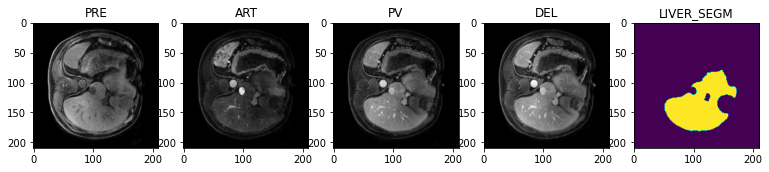

In [26]:
check_ds = monai.data.Dataset(data=external_test_data_dict[:1], transform=test_transforms)


check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=pad_list_data_collate) #collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['PRE'].shape)
print(check_data['ART'].shape)
print(check_data['PV'].shape)
print(check_data['DEL'].shape)


num_display = 10
if check_data['ART'].shape[0] < num_display:
    num_display = check_data['ART'].shape[0]

for i in range(num_display):
    acc_id, PRE, ART, PV, DEL , liver_label = (check_data['ACCESSION_ID'][i], check_data['PRE'][i][0],check_data['ART'][i][0],check_data['PV'][i][0],check_data['DEL'][i][0], check_data['SEGM'][i][0])
    print(acc_id)
    print('PRE shape: {}, label shape: {}'.format(PRE.shape, liver_label.shape))
    print('PRE mean: {}'.format(np.mean(PRE.numpy())))

    
    print('ART shape: {}, label shape: {}'.format(ART.shape, liver_label.shape))
    print('ART mean: {}'.format(np.mean(ART.numpy())))
    
    
    print('PV shape: {}, label shape: {}'.format(PV.shape, liver_label.shape))
    print('PV mean: {}'.format(np.mean(PV.numpy())))
    
    print('DEL shape: {}, label shape: {}'.format(DEL.shape, liver_label.shape))
    print('DEL mean: {}'.format(np.mean(DEL.numpy())))



    slice_num = ART.shape[2]//2
    
    plt.figure('check', (13, 15))

    plt.subplot(1, 5, 1)
    plt.title('PRE')
    plt.imshow(PRE[:,:,slice_num], cmap='gray')

 
    
    plt.subplot(1, 5, 2)
    plt.title('ART')
    plt.imshow(ART[:,:,slice_num], cmap='gray')

    plt.subplot(1, 5, 3)
    plt.title('PV')
    plt.imshow(PV[:,:,slice_num], cmap='gray')
    
    plt.subplot(1, 5 ,4)
    plt.title('DEL')
    plt.imshow(DEL[:,:,slice_num], cmap='gray')

    

    plt.subplot(1, 5, 5)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    plt.show()


    


In [27]:
roi_size = (224, 224, 128)

df_external_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= external_test_loader, 
        roi_size=roi_size, 
        plot_images=False, 
        save_output=False) #, max_eval = 2

torch.cuda.empty_cache()
df_external_test_results['EXPERIMENT_ID'] = '4mpMRI-Contrast-Imaging'
df_external_test_results.describe()

0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarni

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 181 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 181 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 182 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the 

0.9193833470344543
8.157378823561169
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 27 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 28 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 29 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 27 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 28 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 29 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the predi

0.9203909039497375
3.9376407047435773
inf
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 61 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 62 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 63 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 223 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 224 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 224 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWar

0.9516687393188477
15.186541652150325
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 77 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 78 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 79 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9573757648468018
5.758116754258909
inf
torch.Size([1, 2, 230, 230, 125])
torch.Size([1, 230, 230, 125])
0.9105749130249023
6.676718961138536
inf
0.9111567735671997
4.445971177529993
inf
torch.Size([1, 2, 228, 228, 105])
torch.Size([1, 228, 228, 105])


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 82 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWa

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 82 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: t

0.49121150374412537
47.251766330080976
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 150 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 151 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 152 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning

0.4906649589538574
17.41666666666666
inf
torch.Size([1, 2, 211, 211, 104])
torch.Size([1, 211, 211, 104])


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 172 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 173 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 174 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161:

0.6662546992301941
31.064195328086868
inf
0.6780221462249756
23.42423175674286
inf
torch.Size([1, 2, 191, 167, 118])
torch.Size([1, 191, 167, 118])


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 171 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 171 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")


0.8857805132865906
19.676385911653366
inf
0.9098247289657593
6.575375791475251
inf
torch.Size([1, 2, 211, 211, 109])
torch.Size([1, 211, 211, 109])
0.9111907482147217
17.645932237475417
inf
0.9145158529281616
2.8027530302097476
inf
torch.Size([1, 2, 201, 178, 108])
torch.Size([1, 201, 178, 108])


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 91 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 92 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 93 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

0.8720756769180298
8.66494039137114
inf
0.8721743822097778
8.592821395858465
inf
torch.Size([1, 2, 204, 204, 100])
torch.Size([1, 204, 204, 100])


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 156 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 158 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161:

0.9223992228507996
4.768106058019352
inf
0.9224432706832886
4.760127334615097
inf
torch.Size([1, 2, 189, 189, 105])
torch.Size([1, 189, 189, 105])
0.9040931463241577
25.723135469701816
inf
0.9083569049835205
5.853687958948376
inf
torch.Size([1, 2, 201, 201, 96])
torch.Size([1, 201, 201, 96])
0.7127559185028076
20.517764068393248
inf
0.7126814126968384
20.226787549034416
inf
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 96 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 96 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")


0.9637089967727661
1.584440869320146
inf
0.9638133645057678
1.5068279084285163
inf
torch.Size([1, 2, 210, 210, 110])
torch.Size([1, 210, 210, 110])
0.9187561273574829
10.8060167067076
inf
0.9186668992042542
10.817345060514688
inf
torch.Size([1, 2, 210, 210, 125])
torch.Size([1, 210, 210, 125])


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 135 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 136 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 137 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161:

0.9320769906044006
7.347837723463033
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 134 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 134 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")


0.9335116147994995
5.487602576445723
inf
torch.Size([1, 2, 172, 172, 100])
torch.Size([1, 172, 172, 100])
0.5255099534988403
41.707584418629914
inf
0.4816818833351135
55.12660949235363
inf
torch.Size([1, 2, 221, 221, 114])
torch.Size([1, 221, 221, 114])
0.9433513879776001
2.3926700179176454
inf
0.9433534145355225
2.2560594001686485
inf
torch.Size([1, 2, 207, 207, 105])
torch.Size([1, 207, 207, 105])
[0.9193833470344543, 0.9516687393188477, 0.9105749130249023, 0.49121150374412537, 0.6662546992301941, 0.8857805132865906, 0.9111907482147217, 0.8720756769180298, 0.9223992228507996, 0.9040931463241577, 0.7127559185028076, 0.9637089967727661, 0.9187561273574829, 0.9320769906044006, 0.5255099534988403, 0.9433513879776001]


,DICE,POST_DICE,HD95,POST_HD95,InferenceTime
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.839424,0.839915,16.823213,11.186789,0.006544
std,0.152848,0.159594,13.683737,13.422771,0.002132
min,0.491212,0.481682,1.584441,1.506828,0.004088
25%,0.832246,0.832301,7.180058,4.318889,0.004986
50%,0.910883,0.912836,12.996279,5.805902,0.006300
75%,0.924819,0.925210,21.819107,12.467175,0.007225
max,0.963709,0.963813,47.251766,55.126609,0.011361


In [28]:
df_external_test_results.describe()

,DICE,POST_DICE,HD95,POST_HD95,InferenceTime
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.839424,0.839915,16.823213,11.186789,0.006544
std,0.152848,0.159594,13.683737,13.422771,0.002132
min,0.491212,0.481682,1.584441,1.506828,0.004088
25%,0.832246,0.832301,7.180058,4.318889,0.004986
50%,0.910883,0.912836,12.996279,5.805902,0.006300
75%,0.924819,0.925210,21.819107,12.467175,0.007225
max,0.963709,0.963813,47.251766,55.126609,0.011361


In [29]:
df_external_test_results.to_csv('../ExternalTestingResults/Results-4mpMRI-Net.csv')

# Public LiverHccSeg Dataset for Benchmark Testing

In [30]:
from monai.data import Dataset, DataLoader, pad_list_data_collate

In [31]:
## Load Public LiverHccSeg Dataset

import glob

LiverHccSeg_pre_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art_pre.nii.gz'
LiverHccSeg_art_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art.nii.gz'
LiverHccSeg_pv_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art_pv.nii.gz'
LiverHccSeg_del_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art_del.nii.gz'
LiverHccSeg_segm_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*rater1_liver.nii.gz'

LiverHccSeg_pre_paths = glob.glob(LiverHccSeg_pre_path)
LiverHccSeg_art_paths = glob.glob(LiverHccSeg_art_path)
LiverHccSeg_pv_paths = glob.glob(LiverHccSeg_pv_path)
LiverHccSeg_del_paths = glob.glob(LiverHccSeg_del_path)
LiverHccSeg_segm_paths = glob.glob(LiverHccSeg_segm_path)

LiverHccSeg_accs = []
for i in LiverHccSeg_pre_paths:
    LiverHccSeg_accs.append(i.split('/')[-3])
    
df_LiverHccSeg_imgs = pd.DataFrame({'ACCESSION_ID': LiverHccSeg_accs, 'PRE' : LiverHccSeg_pre_paths,
                                   'ART' : LiverHccSeg_art_paths, 'PV' : LiverHccSeg_pv_paths, 
                                    'DEL' : LiverHccSeg_del_paths, 'SEGM' : LiverHccSeg_segm_paths })

df_LiverHccSeg_imgs

,ACCESSION_ID,PRE,ART,PV,DEL,SEGM
0,TCGA-G3-A25T,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
1,TCGA-G3-AAV2,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
2,TCGA-G3-A3CJ,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
3,TCGA-DD-A4NH,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
4,TCGA-BC-4073,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
5,TCGA-DD-A4NB,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
6,TCGA-G3-A7M7,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
7,TCGA-G3-AAV1,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
8,TCGA-G3-AAV3,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
9,TCGA-G3-AAV7,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...


In [32]:
LiverHccSeg_test_data_dict = df_LiverHccSeg_imgs.to_dict('records')
print('Number of LiverHccSeg testing files: ', len(LiverHccSeg_test_data_dict))

Number of LiverHccSeg testing files:  17


In [33]:
LiverHccSeg_test_ds = monai.data.Dataset(
    data=LiverHccSeg_test_data_dict, transform=test_transforms)
LiverHccSeg_test_loader = DataLoader(LiverHccSeg_test_ds, batch_size=1, num_workers=4)

torch.Size([3, 1, 180, 180, 112])
torch.Size([3, 1, 180, 180, 112])
torch.Size([3, 1, 180, 180, 112])
torch.Size([3, 1, 180, 180, 112])
TCGA-G3-A25T
PRE shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
PRE mean: 0.047792427241802216
ART shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
ART mean: 0.10788898915052414
PV shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
PV mean: 0.10535145550966263
DEL shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
DEL mean: 0.08942414820194244


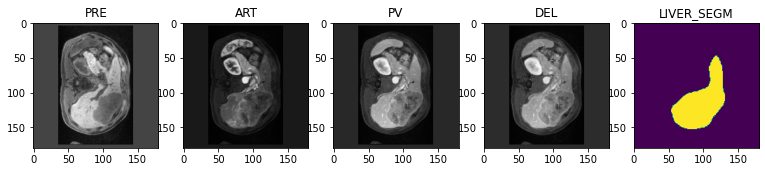

TCGA-G3-AAV2
PRE shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
PRE mean: 0.04522135853767395
ART shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
ART mean: 0.12752416729927063
PV shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
PV mean: 0.15688380599021912
DEL shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
DEL mean: 0.13756035268306732


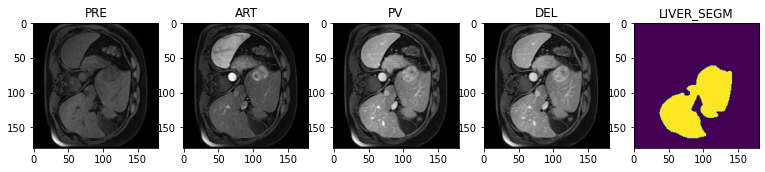

TCGA-G3-A3CJ
PRE shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
PRE mean: -0.0007102181552909315
ART shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
ART mean: 0.060783401131629944
PV shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
PV mean: 0.0006159089389257133
DEL shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
DEL mean: -0.0002303773071616888


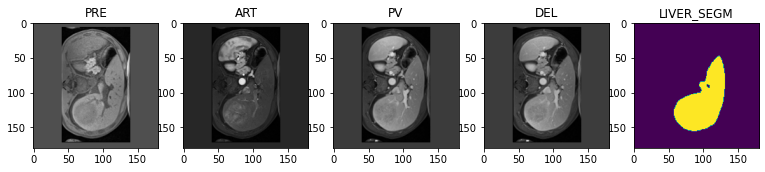

In [34]:
check_ds = monai.data.Dataset(data=LiverHccSeg_test_data_dict[:3], transform=test_transforms)


check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=pad_list_data_collate) #pad_list_data_collate, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['PRE'].shape)
print(check_data['ART'].shape)
print(check_data['PV'].shape)
print(check_data['DEL'].shape)

num_display = 10
if check_data['ART'].shape[0] < num_display:
    num_display = check_data['ART'].shape[0]

for i in range(num_display):
    acc_id, PRE, ART, PV, DEL , liver_label = (check_data['ACCESSION_ID'][i],check_data['PRE'][i][0], check_data['ART'][i][0], check_data['PV'][i][0], check_data['DEL'][i][0], check_data['SEGM'][i][0])
    print(acc_id)
    
    print('PRE shape: {}, label shape: {}'.format(PRE.shape, liver_label.shape))
    print('PRE mean: {}'.format(np.mean(PRE.numpy())))
    
    print('ART shape: {}, label shape: {}'.format(ART.shape, liver_label.shape))
    print('ART mean: {}'.format(np.mean(ART.numpy())))
        
    print('PV shape: {}, label shape: {}'.format(PV.shape, liver_label.shape))
    print('PV mean: {}'.format(np.mean(PV.numpy())))

    
    print('DEL shape: {}, label shape: {}'.format(DEL.shape, liver_label.shape))
    print('DEL mean: {}'.format(np.mean(DEL.numpy())))
    


    slice_num = ART.shape[2]//2
    
    plt.figure('check', (13, 15))

    plt.subplot(1, 5, 1)
    plt.title('PRE')
    plt.imshow(PRE[:,:,slice_num], cmap='gray')
    
    plt.subplot(1, 5, 2)
    plt.title('ART')
    plt.imshow(ART[:,:,slice_num], cmap='gray')

    plt.subplot(1, 5, 3)
    plt.title('PV')
    plt.imshow(PV[:,:,slice_num], cmap='gray')
    
    plt.subplot(1, 5, 4)
    plt.title('DEL')
    plt.imshow(DEL[:,:,slice_num], cmap='gray')
    

    plt.subplot(1, 5, 5)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    plt.show()


    


0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 147 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 148 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 149 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161:

0.8709120750427246
11.29078664852764
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the 

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the predicti

0.871343731880188
9.710227260779456
inf
torch.Size([1, 2, 170, 107, 100])
torch.Size([1, 170, 107, 100])


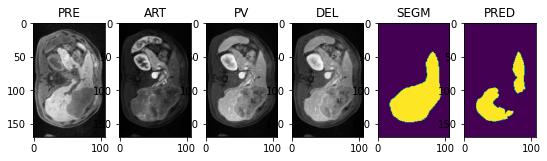

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 28 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 29 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 30 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 28 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 29 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 30 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarnin

0.9491243362426758
4.09547869554112
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 30 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 31 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 32 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 30 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 31 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 32 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the predi

0.9498753547668457
2.1058776545100235
inf
torch.Size([1, 2, 180, 180, 110])
torch.Size([1, 180, 180, 110])


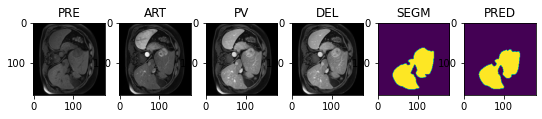

0.9186370968818665
10.265982671916344
inf
0.9189307689666748
8.703092710519403
inf
torch.Size([1, 2, 165, 98, 112])
torch.Size([1, 165, 98, 112])


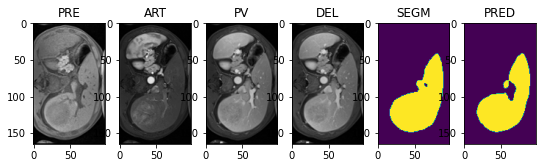

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 179 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 180 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 181 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161:

0.7849050760269165
26.286581618945196
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 189 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 190 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 191 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning

0.7963829040527344
20.987883665216394
inf
torch.Size([1, 2, 201, 151, 86])
torch.Size([1, 201, 151, 86])


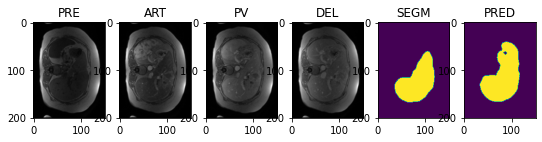

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 54 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 55 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 56 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 54 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 55 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 56 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarnin

0.9433428049087524
4.496474772115418
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 55 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 56 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 57 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9436596035957336
2.10941447060788
inf
torch.Size([1, 2, 200, 150, 120])
torch.Size([1, 200, 150, 120])


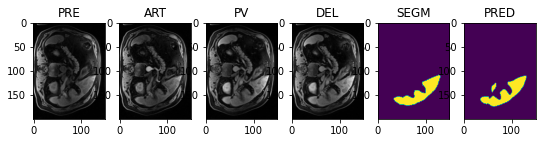

0.9398108720779419
2.210694513898805
inf
0.9398108720779419
2.210694513898805
inf
torch.Size([1, 2, 201, 200, 115])
torch.Size([1, 201, 200, 115])


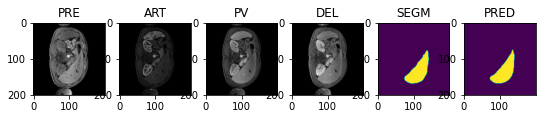

0.9532560706138611
17.767624720017
inf
0.9569686651229858
2.395142255749954
0.5717570091206958
torch.Size([1, 2, 190, 155, 96])
torch.Size([1, 190, 155, 96])


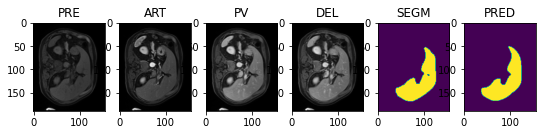

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 79 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 80 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 79 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 80 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarnin

0.9097932577133179
4.146642162939117
inf
0.9097932577133179
4.146642162939117
inf
torch.Size([1, 2, 225, 204, 122])
torch.Size([1, 225, 204, 122])


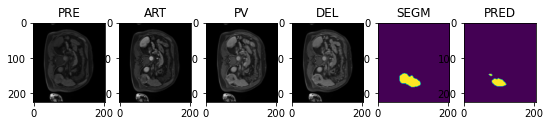

0.9396041631698608
5.70462652733109
inf
0.9406551122665405
2.5358563113483865
inf
torch.Size([1, 2, 175, 175, 110])
torch.Size([1, 175, 175, 110])


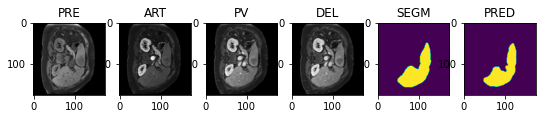

0.890069842338562
28.66160076658878
inf
0.905671238899231
7.975274091221614
inf
torch.Size([1, 2, 180, 119, 150])
torch.Size([1, 180, 119, 150])


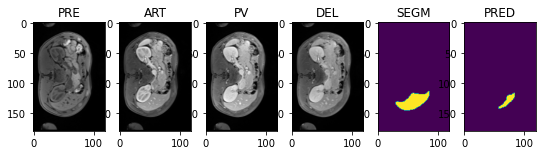

0.9391330480575562
5.809190788322158
inf
0.9397348165512085
3.5133315168765087
inf
torch.Size([1, 2, 180, 147, 110])
torch.Size([1, 180, 147, 110])


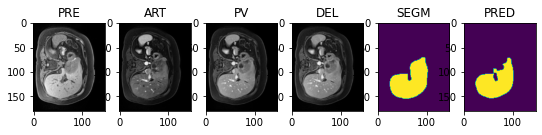

0.9539045095443726
6.260567717702355
inf
0.9549034833908081
2.5808463245623905
inf
torch.Size([1, 2, 200, 163, 153])
torch.Size([1, 200, 163, 153])


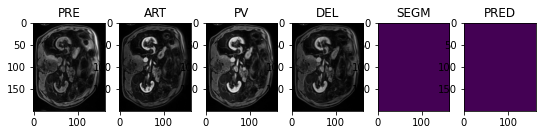

0.9061943292617798
7.71271314930153
inf
0.9070627689361572
6.1030168876192885
inf
torch.Size([1, 2, 215, 162, 125])
torch.Size([1, 215, 162, 125])


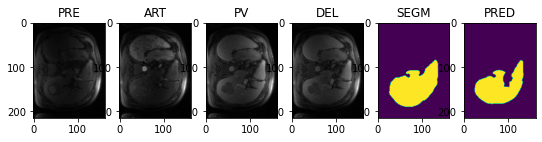

0.9337658286094666
3.3155577902426585
inf
0.9337694644927979
3.3130577902426586
inf
torch.Size([1, 2, 201, 201, 99])
torch.Size([1, 201, 201, 99])


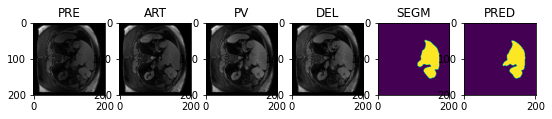

0.8185622692108154
33.85560785439027
inf
0.8221139907836914
26.042371502152456
inf
torch.Size([1, 2, 191, 143, 98])
torch.Size([1, 191, 143, 98])


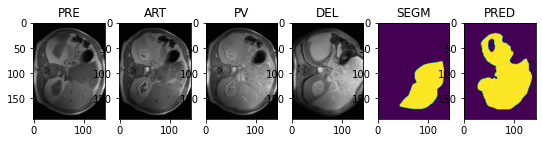

0.9186712503433228
8.083623466703443
inf
0.9198703765869141
2.792720290053133
inf
torch.Size([1, 2, 201, 151, 90])
torch.Size([1, 201, 151, 90])


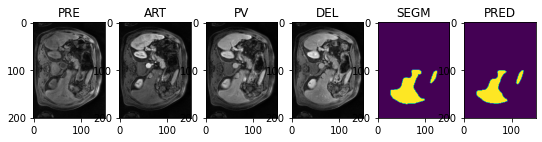

0.8935661315917969
9.564701218718389
inf
0.8963274955749512
4.292723318563954
inf
torch.Size([1, 2, 201, 151, 105])
torch.Size([1, 201, 151, 105])


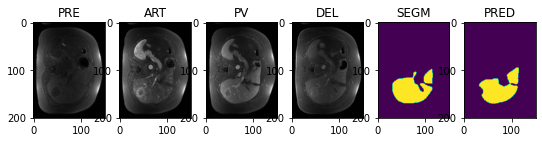

[0.8709120750427246, 0.9491243362426758, 0.9186370968818665, 0.7849050760269165, 0.9433428049087524, 0.9398108720779419, 0.9532560706138611, 0.9097932577133179, 0.9396041631698608, 0.890069842338562, 0.9391330480575562, 0.9539045095443726, 0.9061943292617798, 0.9337658286094666, 0.8185622692108154, 0.9186712503433228, 0.8935661315917969]


,DICE,POST_DICE,HD95,POST_HD95,InferenceTime
count,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.909603,0.912169,11.148733,6.559893,0.004507
std,0.047425,0.045181,9.637483,6.880108,0.001258
min,0.784905,0.796383,2.210695,2.105878,0.003495
25%,0.893566,0.905671,4.496475,2.535856,0.003765
50%,0.918671,0.919870,7.712713,3.513332,0.004046
75%,0.939811,0.940655,11.290787,7.975274,0.004524
max,0.953905,0.956969,33.855608,26.042372,0.008130


In [35]:
roi_size = (224, 224, 128)

df_LiverHccSeg_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= LiverHccSeg_test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=False) #, max_eval = 2

torch.cuda.empty_cache()
df_LiverHccSeg_test_results['EXPERIMENT_ID'] = 'LiverHccSeg-PRE-ART-PV-DEL'
df_LiverHccSeg_test_results.describe()

In [36]:
df_LiverHccSeg_test_results.to_csv('../LiverHccSegTestingResults/LiverHccSeg-PRE-ART-PV-DEL.csv')